## Identities point clouds analysis

In [30]:
import numpy as np
from gtda import diagrams
import matplotlib.pyplot as plt
import pickle
import plotly.express as px
import scipy
import plotly.graph_objects as go
from sklearn.decomposition import PCA,KernelPCA
import pandas as pd
from gtda.homology import VietorisRipsPersistence
from tqdm import tqdm
MODEL_NAMES = ["retina_facenet","retina_arcface"]

In [6]:
model = MODEL_NAMES[1]
metadata = pd.read_parquet(f"../../embeddings/CelebA/df_dataset.parquet")
data_npz = np.load(f"../../embeddings/CelebA/embeddings_{model}.npz")
embeddings = data_npz['a']
del data_npz

In [7]:
identities = np.sort(metadata.loc[metadata[f"keep_embeddings_{model}"]==True]["identity"].unique())

In [8]:
identities_pcs = []
for i in identities:
    pc = embeddings[metadata.loc[metadata["identity"]==i].index,:]
    identities_pcs.append(pc)

In [9]:
useful_cols = ['5_o_Clock_Shadow', 'Arched_Eyebrows',
       'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
       'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Male','Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat','Wearing_Necklace', 'Young','rgb_r', 'rgb_g','rgb_b', 'hsv_h', 'hsv_s', 'hsv_v']

In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

id = 40
pca = KernelPCA(n_components=2, kernel="cosine")
pc = identities_pcs[id]
metaid = metadata.loc[metadata["identity"]==identities[id]]
pc_r = pca.fit_transform(pc)

fig = make_subplots(rows=6, cols=7,subplot_titles = useful_cols)

for i in range(6):
    for j in range(7):
        fig.add_trace(go.Scatter(x=pc_r[:,0],y=pc_r[:,1], mode='markers', marker_color = metaid[useful_cols[7*i+j]]), row =i+1, col = j+1)
fig.update_layout(width = 1300, height = 1300, showlegend = False)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

## Centroids and distances

In [18]:
centroids = np.zeros((len(identities),embeddings.shape[1]))
for i in range(len(identities)):
    centroids[i,:] = identities_pcs[i].mean(axis = 0)


In [21]:
id = 1000
D = np.zeros(len(identities))
for j in range(len(identities)):
    #D[j] = np.sqrt(np.sum((centroids[id,:]-centroids[j,:])**2))
    D[j] = scipy.spatial.distance.cosine(centroids[id,:],centroids[j,:])

id_D = np.argsort(D)

In [22]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

topk = 20

fig = make_subplots(rows=1, cols=topk, subplot_titles=[f"id: {id_D[k]}, D: {np.round(D[id_D][k],1)}" for k in range(topk)])
for k in range(topk):
    idx = id_D[k]
    pca = KernelPCA(n_components=2, kernel="cosine")
    pc_r = pca.fit_transform(identities_pcs[idx])
    fig.add_trace(go.Scatter(x=pc_r[:,0],y=pc_r[:,1], mode='markers'), row =1, col = k+1)
fig.update_layout(width = 200*topk, height = 350, showlegend = False)
# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)
fig.show()

In [25]:
res_land = []
res_heat = []
res_bett = []

def new_max(A):
    return np.max(A)

for id in tqdm(range(len(identities))): 
    D = np.zeros(len(identities))
    for j in range(len(identities)):
        D[j] = np.sqrt(np.sum((centroids[id,:]-centroids[j,:])**2))

    id_D = np.argsort(D)
    topk_c = 100
    persistence = VietorisRipsPersistence(
        metric = "cosine",
        homology_dimensions=[0],
        n_jobs =-1,
        reduced_homology=True,
    )

    p_diagrams = persistence.fit_transform([identities_pcs[id_D[k]] for k in range(topk_c)])
    
    diagramScaler = diagrams.Scaler(function=new_max)
    p_diagrams = diagramScaler.fit_transform(p_diagrams)

    dist = diagrams.PairwiseDistance(metric = "landscape")
    Dph = dist.fit_transform(p_diagrams)
    res_land.append(Dph[0,:])

    dist = diagrams.PairwiseDistance(metric = "heat")
    Dph = dist.fit_transform(p_diagrams)
    res_heat.append(Dph[0,:])

    dist = diagrams.PairwiseDistance(metric = "betti")
    Dph = dist.fit_transform(p_diagrams)
    res_bett.append(Dph[0,:])
    

100%|██████████| 2036/2036 [06:52<00:00,  4.93it/s]


Text(0, 0.5, 'Distance between PDs')

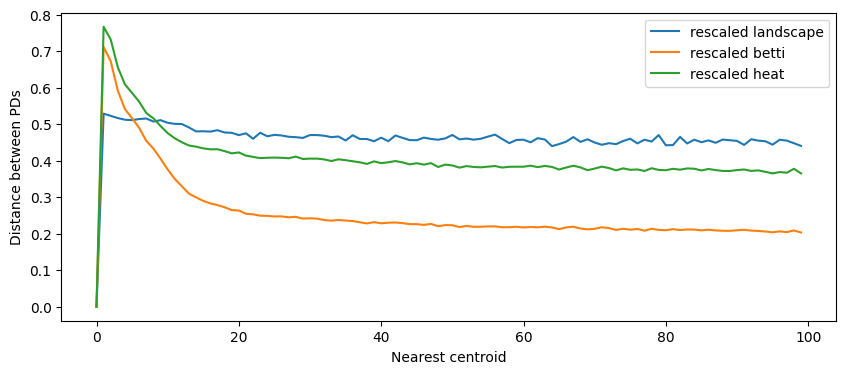

In [27]:
f,ax = plt.subplots(1,1,figsize = (10,4))
ax.plot(np.mean(res_land,axis = 0)/np.max(res_land), label = "rescaled landscape")
ax.plot(np.mean(res_bett,axis = 0)/np.max(res_bett), label = "rescaled betti")
ax.plot(np.mean(res_heat,axis = 0)/np.max(res_heat), label = "rescaled heat")
ax.legend()
ax.set_xlabel("Nearest centroid")
ax.set_ylabel("Distance between PDs")

## Separation of attributes in pc

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC

In [95]:
attributes = ['5_o_Clock_Shadow', 'Arched_Eyebrows',
       'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
       'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young']
attributes = np.array(attributes)

In [168]:
errs = np.zeros((len(identities),len(attributes)))
entropy = np.zeros((len(identities),len(attributes)))

for i in tqdm(range(len(identities))):
    emb = identities_pcs[i]
    meta_id = metadata.loc[metadata["identity"] == identities[i]].reset_index()
    for j,att in enumerate(attributes):
        y = meta_id[att].values
        if len(np.unique(y))>1:
            svm_model = SVC(kernel=cosine_similarity)
            svm_model.fit(emb, y)
            y_pred = svm_model.predict(emb)
            errs[i,j] = np.sum(np.abs(y-y_pred)/2)/len(y)
        else:
            errs[i,j] = np.nan
        p1 = np.sum(y == 1)/len(y)
        pm1 = np.sum(y == -1)/len(y)
        if p1 == 0.0:
            p1 = 1
        if pm1 == 0.0:
            pm1 = 1  
        entropy[i,j] = - p1*np.log2(p1) - pm1*np.log2(pm1);

100%|██████████| 2036/2036 [01:11<00:00, 28.40it/s]


In [189]:
ids = np.argwhere(np.median(entropy,0)>=0.4).T[0]

Text(0, 0.5, 'Classification error')

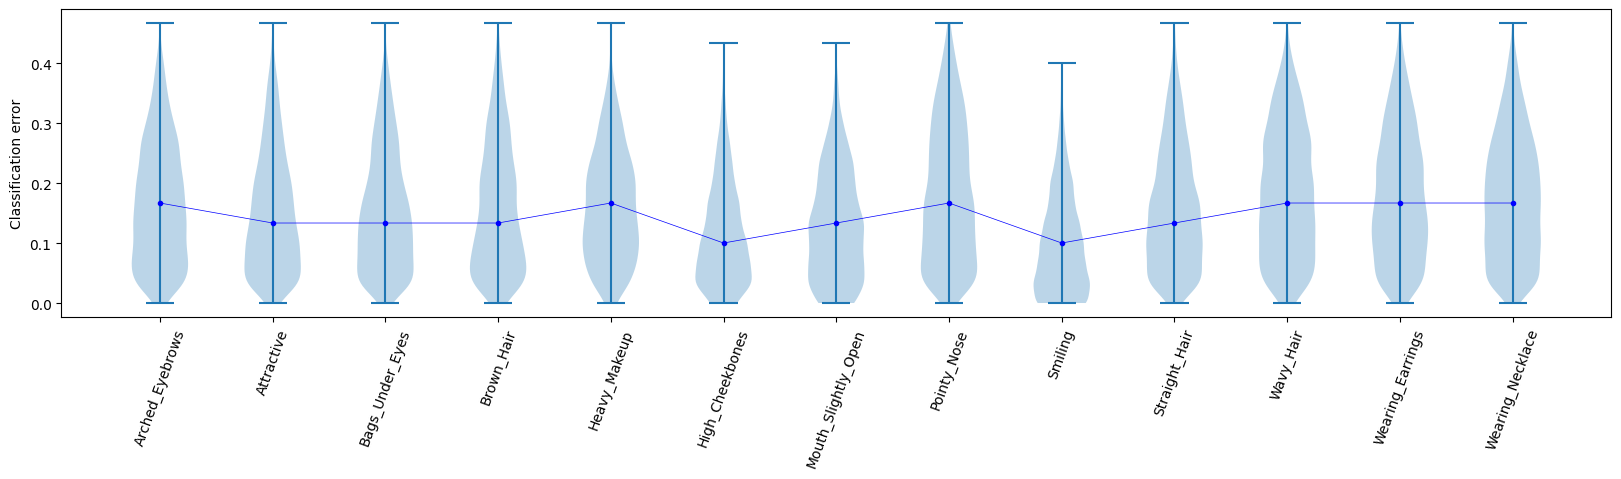

In [190]:
f,ax = plt.subplots(1,1,figsize = (20,4))
#ax.plot(np.arange(1,len(attributes[ids])+1),np.median(entropy[:,ids],0))
mask = ~np.isnan(errs)
filtered_errs = [np.array(d[m]) for d, m in zip(errs.T, mask.T)]
filtered_errs = [filtered_errs[i] for i in ids]
ax.violinplot(filtered_errs)
ax.plot(np.arange(1,len(attributes[ids])+1),np.nanmedian(errs[:,ids],0), '.-', color = "blue", linewidth = 0.5)
ax.set_xticks(np.arange(1,len(attributes[ids])+1))
ax.set_xticklabels(attributes[ids], rotation = 70);
ax.set_ylabel("Classification error")

Smiling

In [194]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

n_ids = 10
ids = np.random.choice(np.arange(len(identities)),n_ids,replace=False)
fig = make_subplots(rows=1, cols=n_ids, subplot_titles=[f"id: {identities[ids[k]]}" for k in range(n_ids)])
for k in range(n_ids):
    idx = ids[k]
    metaid = metadata.loc[metadata["identity"]==identities[idx]]
    pca = KernelPCA(n_components=2, kernel="cosine")
    pc_r = pca.fit_transform(identities_pcs[idx])
    fig.add_trace(go.Scatter(x=pc_r[:,0],y=pc_r[:,1], mode='markers', marker_color = metaid["Mouth_Slightly_Open"]), row =1, col = k+1)

fig.update_layout(width = 200*n_ids, height = 350, showlegend = False)

fig.show()

## Toy model on sphere

In [222]:
x.shape

(5, 3)

In [322]:
from scipy.spatial.distance import cosine

In [324]:
np.array([cosine(xs[-1][i,:],x[n,:]) for i in range(n_samples)])


array([0.00360521, 0.03020848, 0.04989256, 0.01725909, 0.08752019])

In [340]:
n_dim = 3
n_samples = 5

x = 4*np.random.rand(n_samples,n_dim)-2
x = (x.T/np.linalg.norm(x,axis= 1)).T
xs = []
for n in range(n_samples):
    xs.append(np.random.multivariate_normal(x[n,:],0.03*np.eye(n_dim),size = 100))
    xs[-1] = xs[-1][np.array([cosine(xs[-1][i,:],x[n,:]) for i in range(100)]) > 0.02,:]
    xs[-1] = (xs[-1].T/np.linalg.norm(xs[-1], axis = 1)).T


In [341]:
fig = go.Figure()
for i in range(n_samples):
    fig.add_trace(go.Scatter3d(x=xs[i][:,0], y=xs[i][:,1], z=xs[i][:,2],mode='markers', marker=dict(size=5)))

fig.add_trace(go.Scatter3d(x=x[:,0], y=x[:,1], z=x[:,2],mode='markers',marker=dict(color="black")))

fig.show()

In [342]:
D = np.array([[cosine(x[i,:],x[j,:]) for j in range(n_samples)] for i in range(n_samples)])
D

array([[0.        , 1.68568088, 0.7906986 , 0.75946519, 0.73465106],
       [1.68568088, 0.        , 0.6806779 , 0.47096347, 1.78807335],
       [0.7906986 , 0.6806779 , 0.        , 0.20806521, 1.83497897],
       [0.75946519, 0.47096347, 0.20806521, 0.        , 1.81862679],
       [0.73465106, 1.78807335, 1.83497897, 1.81862679, 0.        ]])

In [343]:
fig = make_subplots(rows=1, cols=n_samples)
for k in range(n_samples):
    pca = KernelPCA(n_components=2, kernel="cosine")
    pc_r = pca.fit_transform(xs[k])
    fig.add_trace(go.Scatter(x=pc_r[:,0],y=pc_r[:,1], mode='markers'), row =1, col = k+1)
fig.update_layout(width = 220*n_samples, height = 350, showlegend = False)
fig.show()